# 基于内容的推荐算法

目标：  
        基于内容的推荐方法是非常直接的，它以物品的内容描述信息为依据来做出的推荐，本质上是基于对物品和用户自身的特征或属性的直接分析和计算。
例如，假设已知电影A是一部喜剧，而恰巧我们得知某个用户喜欢看喜剧电影，那么我们基于这样的已知信息，就可以将电影A推荐给该用户。  
算法原理：  
TF-IDF**自然语言处理领域中计算文档中词或短语的权值的方法**，是**词频**（Term Frequency，TF）和逆转文档频率（Inverse Document Frequency，IDF）的乘积。TF指的是某一个给定的词语在该文件中出现的次数。这个数字通常会被正规化，以防止它偏向长的文件（同一个词语在长文件里可能会比短文件有更高的词频，而不管该词语重要与否）。IDF是一个词语普遍重要性的度量，某一特定词语的IDF，可以由总文件数目除以包含该词语之文件的数目，再将得到的商取对数得到。

In [201]:
import numpy as np
import pandas as pd
import collections
from functools import reduce

## 数据集构建

In [38]:
df = pd.read_csv("data/tags.csv", usecols=range(3))
movies = pd.read_csv("data/movies.csv", index_col="movieId")

In [39]:
# 每一部电影的标签信息
tags = df.groupby(by="movieId")["tag"].agg([list])
tags[:3]

,list
movieId,
1,"[pixar, pixar, fun]"
2,"[fantasy, magic board game, Robin Williams, game]"
3,"[moldy, old]"


In [40]:
# genres划分
movies["genres"] = movies["genres"].apply(lambda x: x.split("|"))

In [41]:
movies.head(3)

,title,genres
movieId,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
2,Jumanji (1995),"[Adventure, Children, Fantasy]"
3,Grumpier Old Men (1995),"[Comedy, Romance]"


In [51]:
# 给电影打上新的标签
movies_index = set(movies.index)&set(tags.index)
new_tags = tags.loc[list(movies_index)]
ret = movies.join(new_tags)
ret.head()

,title,genres,list
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[pixar, pixar, fun]"
2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, magic board game, Robin Williams, game]"
3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old]"
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",NaN
5,Father of the Bride Part II (1995),[Comedy],"[pregnancy, remake]"


In [52]:
# 标签的合并，如果没有具体的标签数据则置为空列表
movies_dataset = pd.DataFrame(map(
    lambda x:(x[0], x[1], x[2], x[2]+x[3]) if x[3] is not np.nan 
                                  else(x[0], x[1], x[2], []), ret.itertuples()), columns=["movieId", "title", "genres","tags"])
movies_dataset.head()

,movieId,title,genres,tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Children, Comedy, Fanta..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[Adventure, Children, Fantasy, fantasy, magic ..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[Comedy, Romance, moldy, old]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[]
4,5,Father of the Bride Part II (1995),[Comedy],"[Comedy, pregnancy, remake]"


In [53]:
movies_dataset.set_index("movieId", inplace=True)
movies_dataset.head()

,title,genres,tags
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Children, Comedy, Fanta..."
2,Jumanji (1995),"[Adventure, Children, Fantasy]","[Adventure, Children, Fantasy, fantasy, magic ..."
3,Grumpier Old Men (1995),"[Comedy, Romance]","[Comedy, Romance, moldy, old]"
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[]
5,Father of the Bride Part II (1995),[Comedy],"[Comedy, pregnancy, remake]"


## 物品画像

### TF-IDF提取关键词,构建电影画像

In [62]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from pprint import pprint

In [63]:
# 基于文本的分词,对不同电影计算其相应的TFIDF值
datasets = movies_dataset["tags"].values
datasets

array([list(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'pixar', 'pixar', 'fun']),
       list(['Adventure', 'Children', 'Fantasy', 'fantasy', 'magic board game', 'Robin Williams', 'game']),
       list(['Comedy', 'Romance', 'moldy', 'old']), ..., list([]),
       list([]), list([])], dtype=object)

In [70]:
# 显示电影的tag
datasets[0:2]

array([list(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'pixar', 'pixar', 'fun']),
       list(['Adventure', 'Children', 'Fantasy', 'fantasy', 'magic board game', 'Robin Williams', 'game'])],
      dtype=object)

In [77]:
# 获取（词索引，词频）
dic = Dictionary(datasets)  # 根据文本创建字典
corpus = [dic.doc2bow(line) for line in datasets]
corpus[:2]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)],
 [(0, 1), (2, 1), (4, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]

In [83]:
datasets[0]

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'pixar',
 'pixar',
 'fun']

In [84]:
dic.get(0), dic.get(1), dic.get(2)

('Adventure', 'Animation', 'Children')

In [97]:
dic[5]

'fun'

In [91]:
# 计算TFIFD值　(词索引, TFIDF值)
model = TfidfModel(corpus=corpus)
model[corpus[1]]

[(0, 0.20506508893148376),
 (2, 0.250737357659749),
 (4, 0.23699778877133218),
 (7, 0.4358410782580723),
 (8, 0.39847806133235253),
 (9, 0.49506005899914796),
 (10, 0.49506005899914796)]

In [100]:
movie_profile = {}

for i, mid in enumerate(movies_dataset.index):
    vector = model[corpus[i]]
    # 获取Top-N的关键词
    movie_tag = sorted(vector, key=lambda x:x[1], reverse=True)[:30]
    movie_profile[mid] = dict(map(lambda x: (dic[x[0]], x[1]), movie_tag))

In [108]:
# 获得每一部电影的相对应的TFIDF值
for key, value in movie_profile.items():
    print(key, "\n", value)
    break

1 
 {'pixar': 0.837374709121301, 'fun': 0.34531665530514855, 'Animation': 0.21562355612017706, 'Children': 0.21205621229134275, 'Fantasy': 0.2004362408431816, 'Adventure': 0.17342978500637887, 'Comedy': 0.1335891911679789}


### 完善画像关键词

In [115]:
_movie_profile = []

for i, data in enumerate(movies_dataset.itertuples()):
    mid = data[0]
    title = data[1]
    genres = data[2]
    
    # 获得TFIFD值
    vector = model[corpus[i]]
    movie_tag = sorted(vector, key=lambda x:x[1], reverse=True)[:30]
    TopN_tags_weight = dict(map(lambda x: (dic[x[0]], x[1]), movie_tag))
    
    # 加入类别词，初始权重1
    for g in genres:
        TopN_tags_weight[g] = 1.0
    
    # 获取相对应的tag
    TopN_tag = [i[0] for i in TopN_tags_weight.items()]
    _movie_profile.append((mid, title, TopN_tag, TopN_tags_weight))

In [117]:
_movie_profile[1]

(2,
 'Jumanji (1995)',
 ['game',
  'magic board game',
  'Robin Williams',
  'fantasy',
  'Children',
  'Fantasy',
  'Adventure'],
 {'Adventure': 1.0,
  'Children': 1.0,
  'Fantasy': 1.0,
  'Robin Williams': 0.4358410782580723,
  'fantasy': 0.39847806133235253,
  'game': 0.49506005899914796,
  'magic board game': 0.49506005899914796})

In [118]:
TopN_tags_weight

{'Comedy': 1.0}

In [120]:
# 得到电影画像，主要包括tag及其相对应的TFIFD值
movie_profile = pd.DataFrame(_movie_profile, columns=["movieId", "title", "profile", "weights"])
movie_profile.set_index("movieId", inplace=True)
movie_profile.head()

,title,profile,weights
movieId,,,
1,Toy Story (1995),"[pixar, fun, Animation, Children, Fantasy, Adv...","{'pixar': 0.837374709121301, 'fun': 0.34531665..."
2,Jumanji (1995),"[game, magic board game, Robin Williams, fanta...","{'game': 0.49506005899914796, 'magic board gam..."
3,Grumpier Old Men (1995),"[moldy, old, Romance, Comedy]","{'moldy': 0.669101789463952, 'old': 0.66910178..."
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","{'Comedy': 1.0, 'Drama': 1.0, 'Romance': 1.0}"
5,Father of the Bride Part II (1995),"[pregnancy, remake, Comedy]","{'pregnancy': 0.7029528753875794, 'remake': 0...."


In [281]:
list(movie_profile["weights"].iteritems())[:2]

[(1,
  {'Adventure': 1.0,
   'Animation': 1.0,
   'Children': 1.0,
   'Comedy': 1.0,
   'Fantasy': 1.0,
   'fun': 0.34531665530514855,
   'pixar': 0.837374709121301}),
 (2,
  {'Adventure': 1.0,
   'Children': 1.0,
   'Fantasy': 1.0,
   'Robin Williams': 0.4358410782580723,
   'fantasy': 0.39847806133235253,
   'game': 0.49506005899914796,
   'magic board game': 0.49506005899914796})]

### 倒排序索引
目标：通过关键特征推荐电影

In [143]:
inverted_table = {}
for mid, weights in movie_profile["weights"].iteritems():
    for tag, weight in weights.items():
        # 为每一tag申请一个空列表来存放相对应的（mid, weights）
        _ = inverted_table.get(tag, [])
        _.append((mid, weight))
        inverted_table.setdefault(tag, _)

In [284]:
# tag:(mid, weight)
inverted_table["fun"]

[(1, 0.34531665530514855),
 (89745, 0.3284369053807601),
 (108932, 0.31964654815096755),
 (122918, 0.747908115567127)]

## 用户画像

In [231]:
movies_dataset[:5]

,title,genres,tags
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Children, Comedy, Fanta..."
2,Jumanji (1995),"[Adventure, Children, Fantasy]","[Adventure, Children, Fantasy, fantasy, magic ..."
3,Grumpier Old Men (1995),"[Comedy, Romance]","[Comedy, Romance, moldy, old]"
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",[]
5,Father of the Bride Part II (1995),[Comedy],"[Comedy, pregnancy, remake]"


In [232]:
movie_profile.head()

,title,profile,weights
movieId,,,
1,Toy Story (1995),"[pixar, fun, Animation, Children, Fantasy, Adv...","{'pixar': 0.837374709121301, 'fun': 0.34531665..."
2,Jumanji (1995),"[game, magic board game, Robin Williams, fanta...","{'game': 0.49506005899914796, 'magic board gam..."
3,Grumpier Old Men (1995),"[moldy, old, Romance, Comedy]","{'moldy': 0.669101789463952, 'old': 0.66910178..."
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","{'Comedy': 1.0, 'Drama': 1.0, 'Romance': 1.0}"
5,Father of the Bride Part II (1995),"[pregnancy, remake, Comedy]","{'pregnancy': 0.7029528753875794, 'remake': 0...."


In [233]:
watch_record = pd.read_csv("data/ratings.csv"
                           , usecols=range(2)
                           , dtype={"userId":np.int32, "movieId": np.int32}
                          )
watch_record[:5]

,userId,movieId
0,1,1
1,1,3
2,1,6
3,1,47
4,1,50


In [234]:
watch_record = watch_record.groupby("userId").agg([list])
watch_record.head()

,movieId
,list
userId,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,..."
4,"[21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1..."
5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."


In [271]:
# 用户画像
user_profile = {}

for uid, mids in watch_record.itertuples():
    
    # 获取每一uid 观看电影的信息
    record_movie_profile = movie_profile.loc[list(mids)]
    # 计算最感兴趣的种类
    counter = collections.Counter(reduce(lambda x, y:list(x)+list(y), record_movie_profile["profile"].values))
    interest_word = counter.most_common(50)
    maxcount = interest_word[0][1]
    #　归一化
    interest_word = [(w,round(c/maxcount, 4)) for w,c in interest_word]
    # {uid:{ii1:weight, ii2:weight}}
    user_profile[uid] = interest_word

In [292]:
user_profile[1][:10]

[('Action', 1.0),
 ('Adventure', 0.9444),
 ('Comedy', 0.9222),
 ('Drama', 0.7556),
 ('Thriller', 0.6111),
 ('Fantasy', 0.5222),
 ('Crime', 0.5),
 ('Children', 0.4667),
 ('Sci-Fi', 0.4444),
 ('Animation', 0.3222)]

## 为用户产生TOP-N推荐结果

In [295]:
watch_record

,movieId
,list
userId,
1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
3,"[31, 527, 647, 688, 720, 849, 914, 1093, 1124,..."
4,"[21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1..."
5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."
...,...
606,"[1, 7, 11, 15, 17, 18, 19, 28, 29, 32, 36, 46,..."
607,"[1, 11, 25, 34, 36, 86, 110, 112, 150, 153, 16..."


In [321]:
for uid, interest_words in user_profile.items():
    result_table = {} # [mid,[0.1, 0.6]] 
    # {[('Action', 1.0),]}
    for interest_word, interest_weight in interest_words:
        related_movies = inverted_table[interest_word]
        
        for mid, related_weight in related_movies:
            _ = result_table.get(mid, [])
#             _.append(interest_weight)  # 用户感兴趣的程度
            _.append(related_weight)
            result_table.setdefault(mid, _)   
            
    re_result = map(lambda x:(x[0], sum(x[1])), result_table.items())
    re_result = sorted(re_result, key=lambda x:x[1], reverse=True)[:20]  # topN推荐
    print(uid)
    pprint(re_result)
    break

1
[(81132, 9.0),
 (79132, 7.4707658816195845),
 (4719, 7.0),
 (26701, 7.0),
 (43932, 7.0),
 (52462, 7.0),
 (71999, 7.0),
 (1907, 7.0),
 (2987, 7.0),
 (6902, 7.0),
 (56152, 7.0),
 (108932, 6.259087588583597),
 (198, 6.0),
 (459, 6.0),
 (546, 6.0),
 (2414, 6.0),
 (2617, 6.0),
 (4956, 6.0),
 (6350, 6.0),
 (7235, 6.0)]


## Word2vec

In [322]:
import gensim, logging

In [322]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [331]:
sentense = list(movie_profile["profile"].values) # 句子

In [334]:
model = gensim.models.Word2Vec(sentences=sentense, window=3, min_count=1, iter=20)

2020-08-13 09:29:20,940 : INFO : collecting all words and their counts
2020-08-13 09:29:20,941 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-13 09:29:20,957 : INFO : collected 1524 word types from a corpus of 25473 raw words and 9742 sentences
2020-08-13 09:29:20,958 : INFO : Loading a fresh vocabulary
2020-08-13 09:29:20,965 : INFO : effective_min_count=1 retains 1524 unique words (100% of original 1524, drops 0)
2020-08-13 09:29:20,966 : INFO : effective_min_count=1 leaves 25473 word corpus (100% of original 25473, drops 0)
2020-08-13 09:29:20,978 : INFO : deleting the raw counts dictionary of 1524 items
2020-08-13 09:29:20,979 : INFO : sample=0.001 downsamples 20 most-common words
2020-08-13 09:29:20,980 : INFO : downsampling leaves estimated 6795 word corpus (26.7% of prior 25473)
2020-08-13 09:29:20,987 : INFO : estimated required memory for 1524 words and 100 dimensions: 1981200 bytes
2020-08-13 09:29:20,988 : INFO : resetting layer weights
20

In [345]:
while True:
    words = input("Words:")
    ret = model.wv.most_similar(positive=[words], topn=10)
    print(ret)
    break

Words: fun


[('surreal', 0.999402642250061), ('adventure', 0.9993561506271362), ('fantasy', 0.999342143535614), ('social commentary', 0.999333918094635), ('Tolkein', 0.9993042945861816), ('funny', 0.9993042945861816), ('visually appealing', 0.9992465972900391), ('humorous', 0.9992341995239258), ('sci-fi', 0.9991506338119507), ('Wizards', 0.9991442561149597)]


### Doc2Vector

In [368]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

In [369]:
documents = [TaggedDocument(words, [movie_id]) for movie_id, words in movie_profile["profile"].iteritems()]

In [370]:
documents[:2]

[TaggedDocument(words=['pixar', 'fun', 'Animation', 'Children', 'Fantasy', 'Adventure', 'Comedy'], tags=[1]),
 TaggedDocument(words=['game', 'magic board game', 'Robin Williams', 'fantasy', 'Children', 'Fantasy', 'Adventure'], tags=[2])]

In [371]:
#  计算文档向量
model = Doc2Vec(documents, vector_size=100, window=3, min_count=1, workers=4, epochs=20)

2020-08-13 09:49:53,695 : INFO : collecting all words and their counts
2020-08-13 09:49:53,697 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-08-13 09:49:53,738 : INFO : collected 1524 word types and 193610 unique tags from a corpus of 9742 examples and 25473 words
2020-08-13 09:49:53,739 : INFO : Loading a fresh vocabulary
2020-08-13 09:49:53,746 : INFO : effective_min_count=1 retains 1524 unique words (100% of original 1524, drops 0)
2020-08-13 09:49:53,747 : INFO : effective_min_count=1 leaves 25473 word corpus (100% of original 25473, drops 0)
2020-08-13 09:49:53,758 : INFO : deleting the raw counts dictionary of 1524 items
2020-08-13 09:49:53,760 : INFO : sample=0.001 downsamples 20 most-common words
2020-08-13 09:49:53,761 : INFO : downsampling leaves estimated 6795 word corpus (26.7% of prior 25473)
2020-08-13 09:49:53,768 : INFO : estimated required memory for 1524 words and 100 dimensions: 79425200 bytes
2020-08-13 09:49:53,769 : INFO : re

In [375]:
frame = get_tmpfile("my_doc2vect_model")

In [376]:
model.save(frame)

2020-08-13 09:51:25,581 : INFO : saving Doc2Vec object under /tmp/my_doc2vect_model, separately None
2020-08-13 09:51:25,583 : INFO : storing np array 'vectors_docs' to /tmp/my_doc2vect_model.docvecs.vectors_docs.npy
2020-08-13 09:51:26,211 : INFO : saved /tmp/my_doc2vect_model


In [402]:
words = movie_profile.profile.loc[6]
words

['Action', 'Crime', 'Thriller']

In [ ]:
words1 = movie_profile.profile.loc[5]
words1

In [408]:
movie_profile.profile[4:7]

movieId
5    [pregnancy, remake, Comedy]
6      [Action, Crime, Thriller]
7      [remake, Romance, Comedy]
Name: profile, dtype: object

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt

In [422]:
infer_vector = model.infer_vector(words)
infer_vector

array([-2.31026416e-03,  3.45464200e-02,  1.99114392e-03, -8.83880130e-05,
        3.47464792e-02, -1.34935342e-02, -8.42887734e-04,  1.99268218e-02,
        1.36458529e-02, -1.55902747e-02, -2.23908797e-02, -2.25521214e-02,
       -3.37042124e-03, -1.60901342e-02, -1.27475196e-02, -4.66887429e-02,
       -2.25527287e-02, -3.06116920e-02, -5.28509822e-03,  1.26928026e-02,
        3.07743601e-03,  1.35788210e-02,  5.54616703e-03, -1.82435624e-02,
       -1.43613694e-02, -2.34715417e-02, -3.03593203e-02, -4.74530132e-03,
        8.51310138e-03,  6.46627555e-03,  3.22809140e-03,  1.27420761e-02,
        3.48738804e-02, -1.17461933e-02,  3.34775215e-03, -8.72334745e-03,
        1.27969235e-02, -1.86692532e-02, -2.21336391e-02, -2.24722121e-02,
        1.10186366e-02,  3.03440727e-03, -1.46102812e-02, -6.56190468e-03,
       -9.23128426e-03, -1.86624061e-02,  2.20305379e-02, -2.36496031e-02,
       -4.41820314e-03,  3.31835262e-02, -2.96598803e-02, -1.81519706e-02,
       -3.03307213e-02,  

In [423]:
top = model.docvecs.most_similar([infer_vector], topn=10)
print(top)

[(5505, 0.9883402585983276), (32587, 0.9881415963172913), (2124, 0.9879723191261292), (30812, 0.9879041910171509), (7061, 0.9878513216972351), (61323, 0.9878132343292236), (1779, 0.9877544045448303), (4166, 0.9876800775527954), (6002, 0.9876760244369507), (3512, 0.9876107573509216)]


In [433]:
print("电影：", movie_profile.loc[6]["title"], "\n")
print("推荐电影：")
for iid, weight in top:
    print(movie_profile.loc[iid, :]["title"])

电影： Heat (1995) 

推荐电影：
Suicide Squad (2016)
2001: A Space Odyssey (1968)
Friends with Benefits (2011)
South Park: Bigger, Longer and Uncut (1999)
Margin Call (2011)
The Revenant (2015)
Happy Gilmore (1996)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Unbreakable (2000)
All the King's Men (1949)


In [425]:
infer_vector1 = model.infer_vector(words1)
infer_vector1

array([ 0.0051198 ,  0.06129421,  0.00604609,  0.00568463,  0.05531308,
       -0.01593204, -0.00411742,  0.05129193,  0.03208151, -0.04326396,
       -0.04482697, -0.04322075, -0.00674182, -0.02470632, -0.01986721,
       -0.08314418, -0.05159604, -0.06155486, -0.00835043,  0.03463339,
        0.00568378,  0.03776013,  0.00983758, -0.03972785, -0.02031361,
       -0.03830637, -0.05804105, -0.02203756,  0.00637699,  0.00711801,
        0.01234065,  0.02049166,  0.06944869, -0.02115096, -0.00380144,
       -0.01806285,  0.02065507, -0.03510199, -0.04280055, -0.04147586,
        0.01822461,  0.01236441, -0.0290857 , -0.02578299, -0.01322697,
       -0.0265607 ,  0.04655097, -0.05094584, -0.00748564,  0.07522822,
       -0.0604393 , -0.04335431, -0.04665793,  0.00845462,  0.02637742,
       -0.01311264, -0.0177198 ,  0.04227069,  0.0447677 , -0.01027317,
        0.0641916 ,  0.02439454, -0.02210962, -0.03584355, -0.04489159,
       -0.0212019 ,  0.0668609 ,  0.025981  , -0.09690608,  0.02

In [426]:
top = model.docvecs.most_similar([infer_vector1], topn=10)
print(top)

[(135536, 0.9964977502822876), (924, 0.9964958429336548), (88405, 0.9964617490768433), (2700, 0.9964407086372375), (90439, 0.9964227080345154), (139385, 0.9964029788970947), (104, 0.9963891506195068), (293, 0.9963852763175964), (3994, 0.9963703155517578), (1942, 0.9963667392730713)]


In [432]:
print("电影：", movie_profile.loc[5]["title"], "\n")
print("推荐电影：")
for iid, weight in top:
    print(movie_profile.loc[iid, :]["title"])

电影： Father of the Bride Part II (1995) 

推荐电影：
Suicide Squad (2016)
2001: A Space Odyssey (1968)
Friends with Benefits (2011)
South Park: Bigger, Longer and Uncut (1999)
Margin Call (2011)
The Revenant (2015)
Happy Gilmore (1996)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Unbreakable (2000)
All the King's Men (1949)


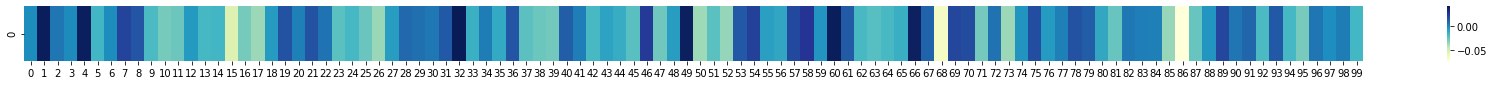

In [405]:
plt.figure(figsize=(30, 1))
sns.heatmap(infer_vector.reshape(1, 100),cmap="YlGnBu")
plt.show()

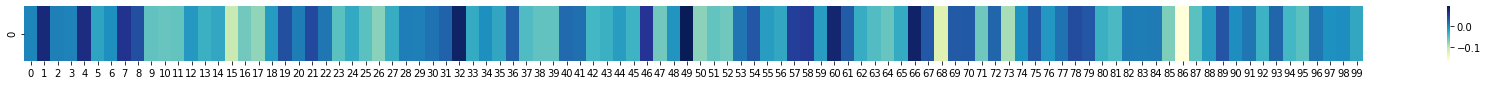

In [406]:
plt.figure(figsize=(30, 1))
sns.heatmap(infer_vector1.reshape(1, 100), cmap="YlGnBu")
plt.show()

## 知识点

In [169]:
T = {}
test = {"a":4, "b":5}
test

{'a': 4, 'b': 5}

In [170]:
# 获取某一key的value值，如果存在返回相对应的值，否则返回[]
b = T.get("a", [])
b.append((11, 4, 5, 6))

In [171]:
# 外部设置键值对
c = T.setdefault("a", b)
c

[(11, 4, 5, 6)]

In [172]:
T

{'a': [(11, 4, 5, 6)]}

In [268]:
a = collections.Counter(reduce(lambda x, y: list(x)+list(y), record_movie_profile["profile"].values))
b = a.most_common()[:10]
b

[('Action', 90),
 ('Adventure', 85),
 ('Comedy', 83),
 ('Drama', 68),
 ('Thriller', 55),
 ('Fantasy', 47),
 ('Crime', 45),
 ('Children', 42),
 ('Sci-Fi', 40),
 ('Animation', 29)]

In [269]:
maxcount = b[0][1]
maxcount

90

In [270]:
for w, c in b:
    print((w, round(c/maxcount, 4)))

('Action', 1.0)
('Adventure', 0.9444)
('Comedy', 0.9222)
('Drama', 0.7556)
('Thriller', 0.6111)
('Fantasy', 0.5222)
('Crime', 0.5)
('Children', 0.4667)
('Sci-Fi', 0.4444)
('Animation', 0.3222)
